# Task 3

In [6]:
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
#import data
data = pd.read_csv('loan_data.csv')
data

,customer_id,credit_lines_outstanding,loan_amt_outstanding,total_debt_outstanding,income,years_employed,fico_score,default
0,8153374,0,5221.545193,3915.471226,78039.38546,5,605,0
1,7442532,5,1958.928726,8228.752520,26648.43525,2,572,1
2,2256073,0,3363.009259,2027.830850,65866.71246,4,602,0
3,4885975,0,4766.648001,2501.730397,74356.88347,5,612,0
4,4700614,1,1345.827718,1768.826187,23448.32631,6,631,0
...,...,...,...,...,...,...,...,...
9995,3972488,0,3033.647103,2553.733144,42691.62787,5,697,0
9996,6184073,1,4146.239304,5458.163525,79969.50521,8,615,0
9997,6694516,2,3088.223727,4813.090925,38192.67591,5,596,0
9998,3942961,0,3288.901666,1043.099660,50929.37206,2,647,0


<Axes: xlabel='default'>

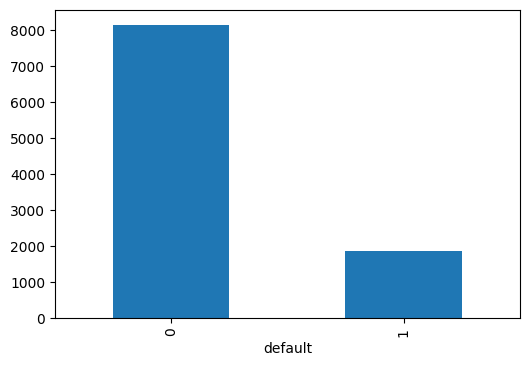

In [8]:
#display counts of defualts and no defaults for the dataset
counts = data['default'].value_counts()
plt.figure(figsize=(6,4))
counts.plot(kind='bar')

# Logistic Regression

In [58]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_auc_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score

#separate features from target variable
X = data.drop(['customer_id','default'],axis=1)
y = data['default']

#scale the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

#split into train and test set
X_train,X_test,y_train,y_test = train_test_split(X_scaled,y,test_size=0.2,stratify=y,random_state=42)

#initialize logistic regression
logreg = LogisticRegression()

#fit the model
logreg.fit(X_train,y_train)

#predict probabilities of class 0 and 1
logreg.predict_proba(X_test)

array([[1.00000000e+00, 2.88012076e-13],
       [9.99825319e-01, 1.74681157e-04],
       [9.99999997e-01, 3.04639415e-09],
       ...,
       [9.99999999e-01, 5.37405839e-10],
       [9.99998989e-01, 1.01086404e-06],
       [1.39930441e-02, 9.86006956e-01]])

In [59]:
#predict test values for logistic regression 
y_pred = logreg.predict(X_test)

#accuracy score 
print(accuracy_score(y_test,y_pred))

0.999


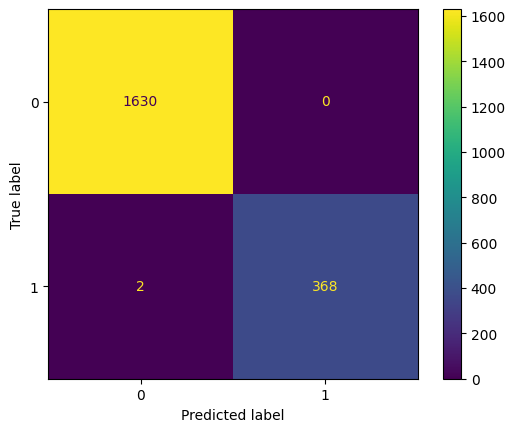

In [21]:
#display confusion matrix
cm = confusion_matrix(y_test,y_pred)
disp = ConfusionMatrixDisplay(cm)
disp.plot()
plt.show()

In [26]:
#calculate logistic regression coefficients
coefficients = logreg.coef_[0]
feature_df = pd.DataFrame({'Feature Name':X.columns, 'Coefficient':coefficients})
feature_df.sort_values(by='Coefficient',ascending=False)

,Feature Name,Coefficient
0,credit_lines_outstanding,8.777903
2,total_debt_outstanding,3.792640
1,loan_amt_outstanding,0.125098
5,fico_score,-1.135441
3,income,-2.330698
4,years_employed,-2.895781


Credit lines outstanding seems to have the highest impact on whether the customer will default

In [29]:
def calculate_expected_loss(model,scaler,features,recovery_rate=0.1):
	#params
	#model: the chosen ML model to calculate default rate
	#scaler: scaler to transform the features
	#features: given features (credit_lines_outstanding, loan_amt_outstanding, total_debt_outstanding, income, years_employed, fico_score)
	#recovery_rate: provided as 0.1
	
	#expected loss = probability of default * Exposure at Default (EAD) * Loss Given Default (LGD)
	#EAD is loan_amt_outstanding, LGD is 1-recovery_rate
	
	#scale features
	scaled_features = scaler.fit_transform([features])

	#calculate default probability 
	probability_default = model.predict_proba(scaled_features)[:,1][0]

	#calculate Loss Given Defualt
	LGD = 1 - recovery_rate

	#Calculate Exposure at Default
	EAD = features[1]

	#calculate expected loss
	expected_loss = probability_default * EAD * LGD

	return expected_loss


# Test Example

In [47]:
#test example borrower
example_borrower = X.iloc[1].values

#calcualte expected loss
example_loss = calculate_expected_loss(logreg,scaler,example_borrower)
example_loss

0.0034018133490942497

The example borrower's expected loss is 0.003, which is very small.

# Decision Tree

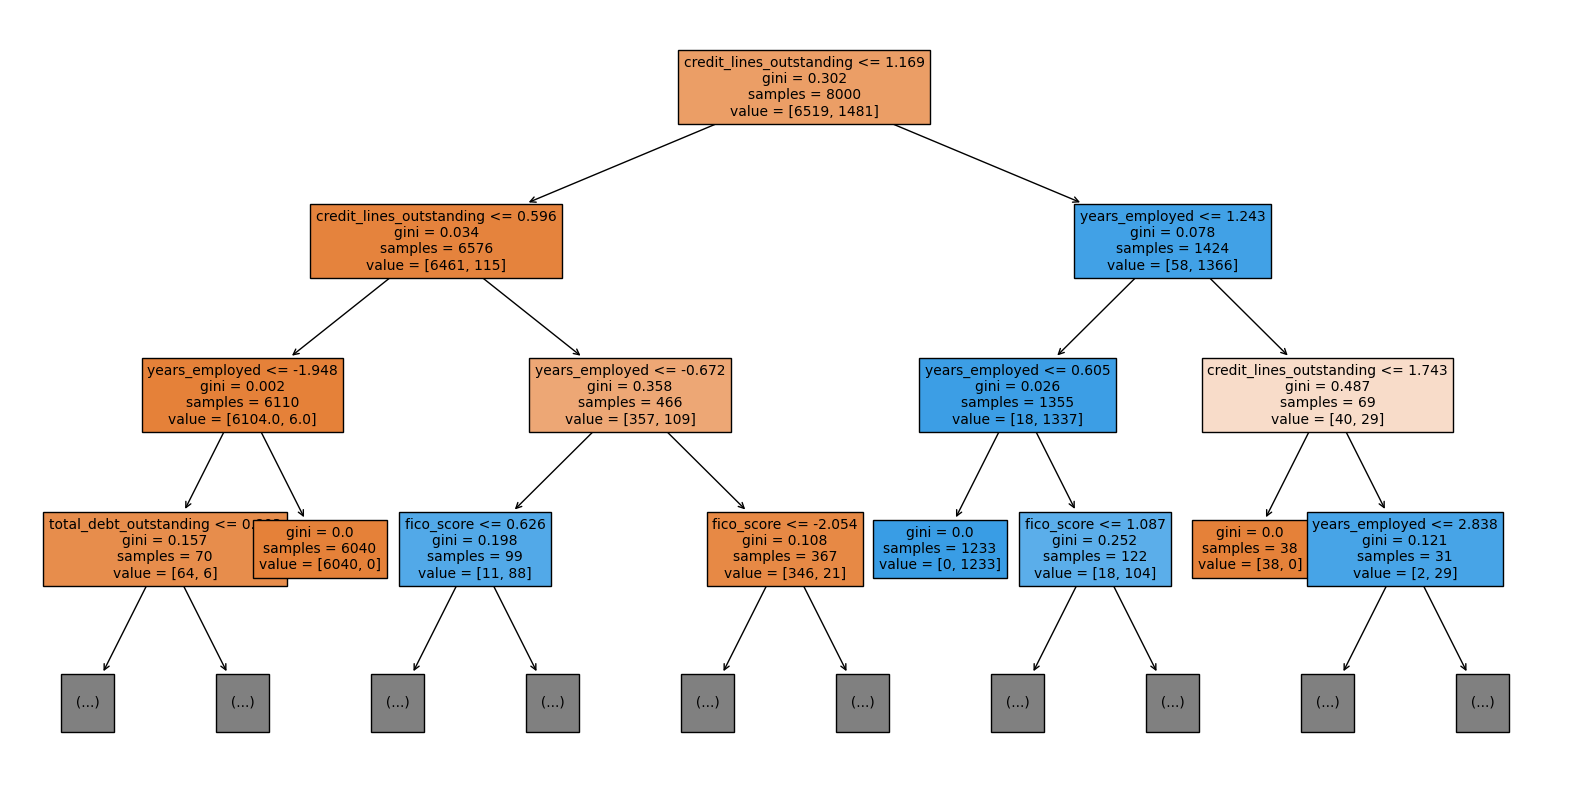

In [43]:
from sklearn.tree import DecisionTreeClassifier,plot_tree

#initialize decision tree classifier
decision_tree = DecisionTreeClassifier()

#fit the model
decision_tree.fit(X_train,y_train)

#plot the decision tree
plt.figure(figsize=(20,10))
plot_tree(decision_tree,filled=True,feature_names=X.columns,max_depth=3,fontsize=10)
plt.show()

0.995


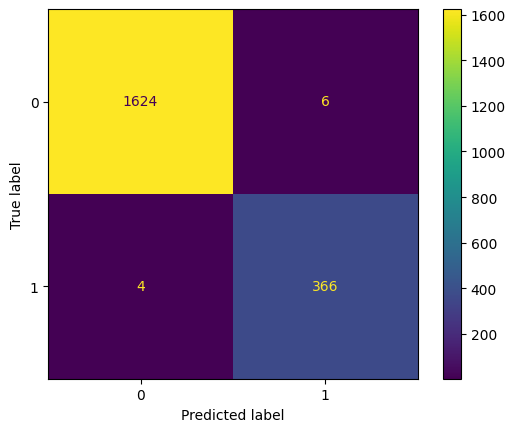

In [60]:
#predict test values
y_pred = decision_tree.predict(X_test)

#calculate accuracy score
print(accuracy_score(y_test,y_pred))

#plot confusion matrix
cm_decision_tree = confusion_matrix(y_test,y_pred)
disp2 = ConfusionMatrixDisplay(cm_decision_tree)
disp2.plot()
plt.show()

In [46]:
#test exmaple borrower lost with decision tree
decision_tree_loss = calculate_expected_loss(decision_tree,scaler,example_borrower)
decision_tree_loss

0.0

The decision tree model gives this example borrower an expected loss of 0.

# Comparative Analysis of Models

In [48]:
#all models i want to test
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

random_state = 42
classifier_models = [
	RandomForestClassifier(random_state=random_state),
    GradientBoostingClassifier(random_state=random_state),
	XGBClassifier(),
	LGBMClassifier()
]
classifier_names = [
	"RandomForestClassifier",
    "GradientBoosting",
	"XGBoost",
	"LGBM"
]

#zip the classifiers into a dictionary
classifiers = dict(zip(classifier_names,classifier_models))
fitted_models = {}

In [52]:
from sklearn import metrics

classifier_dict = dict()

#create a function that prints the test accuracy, f1-score, and train time of each classifier
def display_metrics(classifier,classifiername,y_train,y_test,y_test_pred,time=float('NaN')):

	test_accuracy = metrics.accuracy_score(y_test,y_test_pred)
	f1_score = metrics.f1_score(y_test,y_test_pred)
	train_time = time
	classifier_dict[classifiername] = [classifier,test_accuracy,f1_score,train_time]
	
	print(f"Test Accuracy: {test_accuracy:.4f}, " 
			f"F1-score: {f1_score:.4f}, " 
			f"Train Time: {train_time:.4f} seconds\n")

In [54]:
# to run through all possible models and retrieve their test scores
import time
for clf_name, clf_model in classifiers.items():
	start = time.time()
	clf_model.fit(X_train,y_train)
	end = time.time()
	fitted_models[clf_name] = clf_model
	y_test_pred = clf_model.predict(X_test)
	print(f"Report for {clf_model}:")
	display_metrics(clf_model,clf_name,y_train,y_test,y_test_pred,time=end-start)

Report for RandomForestClassifier(random_state=42):
Test Accuracy: 0.9965, F1-score: 0.9905, Train Time: 0.6439 seconds

Report for GradientBoostingClassifier(random_state=42):
Test Accuracy: 0.9975, F1-score: 0.9932, Train Time: 1.4737 seconds

Report for XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_st

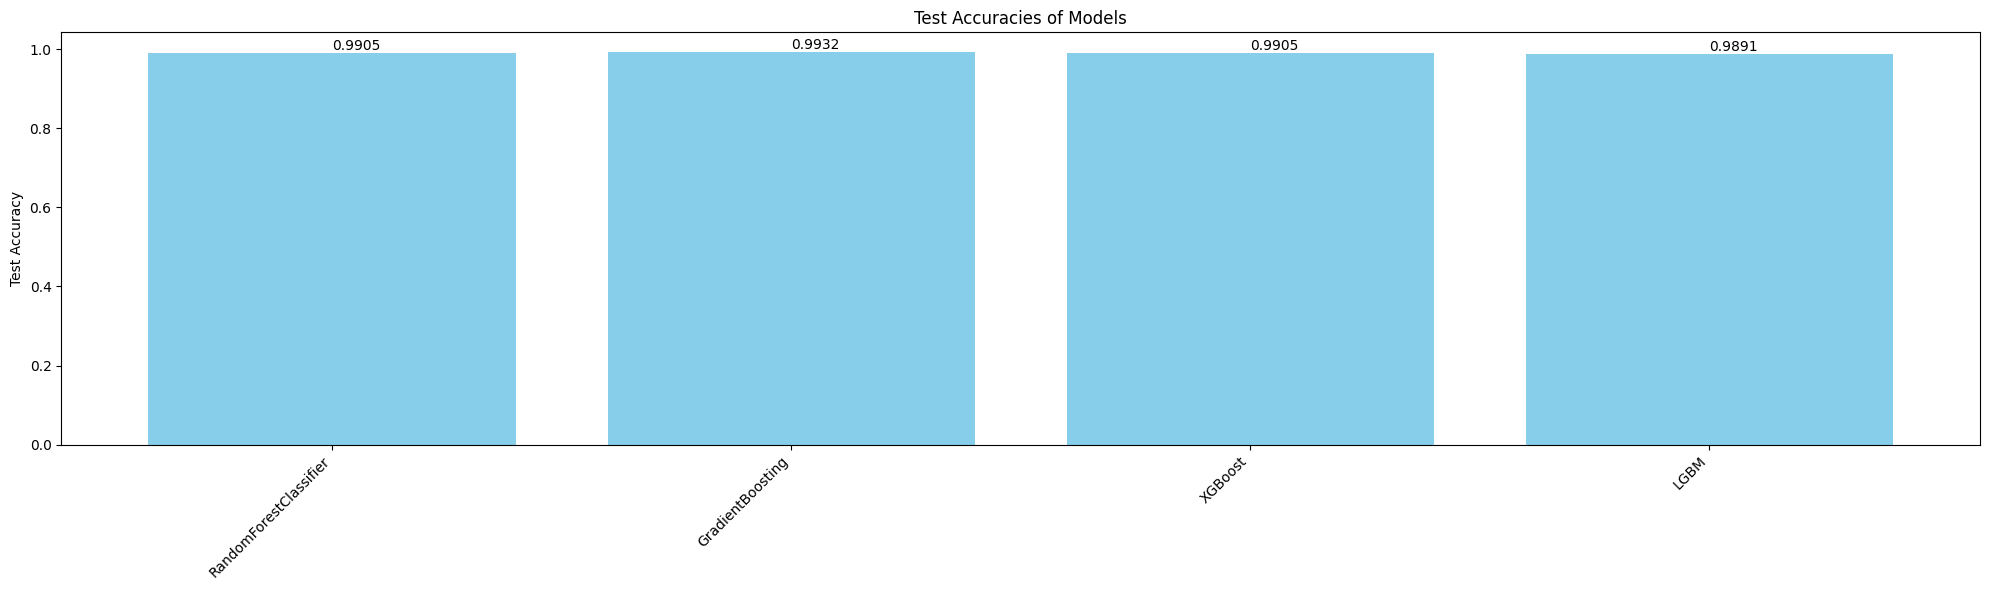

In [55]:
#plot train accuracies, test accuracies, and f1 score of each tested model
def plot_metric_values(data, metric_idx, title, y_label):
    models = list(data.keys())
    values = [model_data[metric_idx] for model_data in data.values()]
    
    plt.figure(figsize=(20, 6))
    bars = plt.bar(models, values, color='skyblue')
    
    # Add the data values on top of the bars
    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2.0, yval, round(yval, 4), va='bottom')

    plt.ylabel(y_label)
    plt.title(title)
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    plt.show()
    
plot_metric_values(classifier_dict, 2, 'Test Accuracies of Models', 'Test Accuracy')

Gradient Boosting seems to have the highest test accuracy with 0.9932.

In [57]:
#test exmaple borrower lost with decision tree
gradient_boosting = GradientBoostingClassifier()
gradient_boosting.fit(X_train,y_train)
decision_tree_loss = calculate_expected_loss(gradient_boosting,scaler,example_borrower)
decision_tree_loss

0.4542704791512026

The Gradient Boosting Algorithm predicts that the expected loss for the example borrower is 0.45. 